In [1]:
import sklearn as sk
import pandas as pd
import datetime
import time
import sys
import numpy as np
import os
import json
import random
import cv2 as cv
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor as dt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import ttest_1samp
#import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV
import pandasql as ps
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from PIL import ImageDraw, Image
import keras.backend as K
import scipy.misc
import numpy as np
import scipy.io
from utils import load_model
from resnet_152 import resnet152_model
import IPython.display as display
import pathlib
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
import zipfile
import imageio
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
train = pd.read_csv("Downloads\\pku-autonomous-driving\\train.csv")
train[0:10]

,ImageId,PredictionString
0,ID_8a6e65317,16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1,ID_337ddc495,66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2,ID_a381bf4d0,43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3,ID_7c4a3e0aa,43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4,ID_8b510fad6,37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...
5,ID_679502721,50 0.173958 1.6934 -3.07 17.2953 5.82861 22.82...
6,ID_f681b269f,70 0.201977 -0.0482845 -3.07942 3.94442 5.6771...
7,ID_2803cf7b5,8 0.172028 3.1064 -3.10087 -18.0211 4.98543 27...
8,ID_89449e126,7 0.156087 -0.0318094 -3.06916 2.83965 2.2697 ...
9,ID_2ad1fc1b3,28 0.1514 0.0071941 -3.10048 2.94173 8.31218 4...


In [3]:
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

In [4]:
points_df = pd.DataFrame()
for col in ['id', 'x', 'y', 'z', 'yaw', 'pitch', 'roll']:
    arr = []
    for ps in train['PredictionString']:
        coords = str2coords(ps)
        arr += [c[col] for c in coords]
    points_df[col] = arr

print('len(points_df)', len(points_df))
points_df.head()

len(points_df) 49684


,id,x,y,z,yaw,pitch,roll
0,16,7.96539,3.20066,11.0225,0.254839,-2.57534,-3.10256
1,56,9.60332,4.66632,19.3390,0.181647,-1.46947,-3.12159
2,70,10.39000,11.22190,59.7825,0.163072,-1.56865,-3.11754
3,70,-9.59236,5.13662,24.7337,0.141942,-3.13950,3.11969
4,46,9.83335,13.26890,72.9323,0.163068,-2.08578,-3.11754


In [5]:
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
           [0, 2305.8757, 1354.9849],
           [0, 0, 1]], dtype=np.float32)

Find 2D coordinates in the image from the 3D given ones

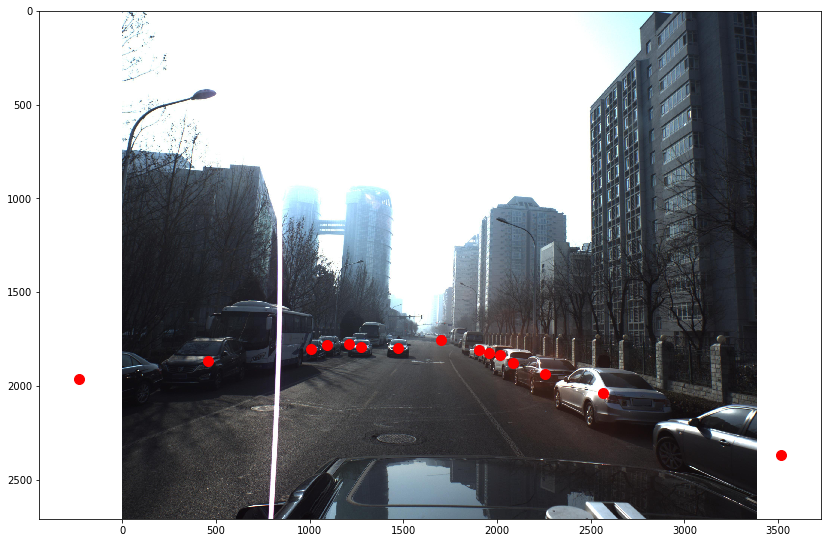

In [12]:
def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image (row)
        ys: y coordinates in the image (column)
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return np.array(list(zip(xs, ys, zs, img_xs, img_ys))).T
plt.figure(figsize=(14,14))
plt.imshow(imread('train_images/' + train['ImageId'][253] + '.jpg'))
plt.scatter(*get_img_coords(train['PredictionString'][253])[3:], color='red', s=100);

For each train image draw the boxes around cars on it proportionally to their z's coordinate: close objects are corresponded to big box and distant objects - to the small boxes. Save these objects as pictures for the training set of network

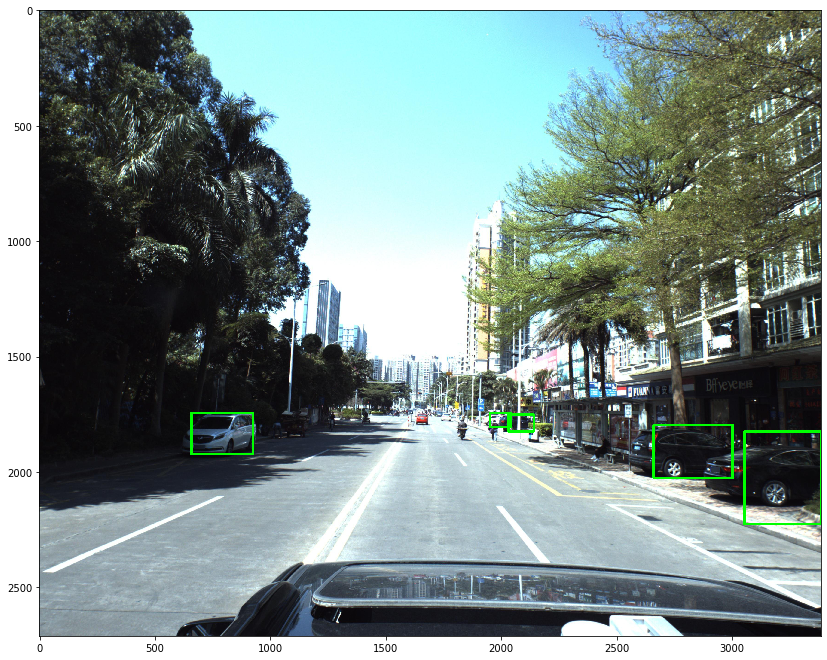

In [13]:
for i in range(0, train.shape[0]):
    img = np.array(Image.open("train_images/" + train['ImageId'][i] + '.jpg'))
    #print(img.shape)
    plt.figure(figsize = (14, 14))
    #plt.imshow(img)
    #plt.show()
    xy = get_img_coords(train['PredictionString'][i])
    for l in range(0, xy[0].shape[0]):

        part = img[int(max(min(img.shape[0], xy[4][l])-22*100/xy[2][l], 0)):int(min(max(0, xy[4][l])+22*100/xy[2][l], 
                                                                                    img.shape[0])),
                   int(max(0, min(img.shape[1], xy[3][l]) - 22*150/xy[2][l])):int(min(max(0, xy[3][l])+22*150/xy[2][l], 
                                                                                      img.shape[1]))]
        
        s_x = int(max(0, min(img.shape[1], xy[3][l]) - 22*150/xy[2][l]))
        s_y = int(max(min(img.shape[0], xy[4][l])-22*100/xy[2][l], 0))
        e_x = int(min(max(0, xy[3][l])+22*150/xy[2][l], img.shape[1]))
        e_y = int(min(max(0, xy[4][l])+22*100/xy[2][l], img.shape[0]))
        cv.rectangle(img, (s_x, s_y), (e_x, e_y), (0, 255, 0), 10)
        plt.imshow(img)
        #plt.title('Matplotlib') #Give this plot a title, 
                                #so I know it's from matplotlib and not cv2
        #plt.show()
        
        #imageio.imwrite('Models/cars/' + str(i) + '_' + str(l) + '.jpg', part)
    break

Creating the background images

In [11]:
random.seed()
h = 224
w = 224
for i in range(0, train.shape[0]):
    img = np.array(Image.open("train_images/" + train['ImageId'][i] + '.jpg'))
    #print(img.shape)
    #plt.imshow(img)
    #plt.show()
    if (i%100 == 0):
        print(i)
    xy = get_img_coords(train['PredictionString'][i])
    for l in range(0, 2):
        t = 0
        while (t == 0):
            t = 1
            rx = random.randint(0, img.shape[1] - h)
            ry = random.randint(0, img.shape[0] - w)
            for j in range (0, xy[0].shape[0]):
                if ((rx - xy[3][j])**2 + (ry - xy[4][j])**2 <= 20000):
                    t = 0
        part = img[ry:ry+h, rx:rx+w]


        imageio.imwrite('Models/bg/' + str(i) + '_1' + str(l) + '.jpg', part)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200


In [27]:
'''
def load_m():
    model = load_model()
    model.layers.pop()
    
    # Freeze all the layers before the `fine_tune_at` layer
    prediction_layer = keras.layers.Dense(1)
    model2 = keras.Sequential([model,prediction_layer])
    #model2.load_weights('my_model.h5')
    
    return model2
'''

Constructing the model from the pre-trained one, freezing some layers and compiling the model

In [4]:
img_width, img_height = 224, 224
num_channels=3
model = resnet152_model(img_width, img_height, num_channels)
#model.load_weights('my_model.h5')
fine_tune_at = 710
print(len(model.layers))
for layer in model.layers[:fine_tune_at]:
    layer.trainable =  False
base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
722
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_zeropadding (ZeroPadding2 (None, 230, 230, 3)  0           data[0][0]                       
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9408        conv1_zeropadding[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_________________________________

res4b12 (Add)                   (None, 14, 14, 1024) 0           scale4b12_branch2c[0][0]         
                                                                 res4b11_relu[0][0]               
__________________________________________________________________________________________________
res4b12_relu (Activation)       (None, 14, 14, 1024) 0           res4b12[0][0]                    
__________________________________________________________________________________________________
res4b13_branch2a (Conv2D)       (None, 14, 14, 256)  262144      res4b12_relu[0][0]               
__________________________________________________________________________________________________
bn4b13_branch2a (BatchNormaliza (None, 14, 14, 256)  1024        res4b13_branch2a[0][0]           
__________________________________________________________________________________________________
scale4b13_branch2a (Scale)      (None, 14, 14, 256)  512         bn4b13_branch2a[0][0]            
__________

res4b35 (Add)                   (None, 14, 14, 1024) 0           scale4b35_branch2c[0][0]         
                                                                 res4b34_relu[0][0]               
__________________________________________________________________________________________________
res4b35_relu (Activation)       (None, 14, 14, 1024) 0           res4b35[0][0]                    
__________________________________________________________________________________________________
res5a_branch2a (Conv2D)         (None, 7, 7, 512)    524288      res4b35_relu[0][0]               
__________________________________________________________________________________________________
bn5a_branch2a (BatchNormalizati (None, 7, 7, 512)    2048        res5a_branch2a[0][0]             
__________________________________________________________________________________________________
scale5a_branch2a (Scale)        (None, 7, 7, 512)    1024        bn5a_branch2a[0][0]              
__________

In [6]:
model.layers[6].name

'pool1'

In [5]:
model.layers[6]

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_inbound_node',
 '_built',
 '_get_node_attribute_at_index',
 '_inbound_nodes',
 '_initial_weights',
 '_losses',
 '_node_key',
 '_non_trainable_weights',
 '_outbound_nodes',
 '_per_input_losses',
 '_per_input_updates',
 '_pooling_function',
 '_trainable_weights',
 '_updates',
 'add_loss',
 'add_update',
 'add_weight',
 'assert_input_compatibility',
 'build',
 'built',
 'call',
 'compute_mask',
 'compute_output_shape',
 'count_params',
 'data_format',
 'from_config',
 'get_config',
 'get_input_at',
 'get_input_mask_at',
 'get_input_shape_at',
 'get_losses_for',
 'get_output_at',
 'get_output_mask_at',
 'ge

In [37]:
len(model.layers)

722

In [14]:
filepath="weights2.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Creating the train and validation set from folders, representing each class: "cars" and "bg"

In [6]:
data_root = 'Models'
img_width, img_height = 224, 224
batch_size = 256

train_image_generator = ImageDataGenerator(validation_split = 0.2)
train_data_gen = train_image_generator.flow_from_directory(seed = 228, batch_size=batch_size,
                                                           directory=data_root,
                                                           shuffle=True,
                                                           target_size=(img_height, img_width),
                                                           class_mode='binary', subset='training')
val_data_gen = train_image_generator.flow_from_directory(seed = 228, batch_size=batch_size,
                                                           directory=data_root,
                                                           shuffle=True,
                                                           target_size=(img_height, img_width),
                                                           class_mode='binary', subset = 'validation')

Found 107682 images belonging to 2 classes.
Found 26919 images belonging to 2 classes.


In [16]:
train_data_gen.class_indices

{'bg': 0, 'cars': 1}

In [8]:
sub_tr = train_data_gen.split()

107682

Training the model

In [ ]:
model.fit_generator(
    train_data_gen,
    steps_per_epoch=300,#train_data_gen.samples // batch_size,
    epochs=15,
    verbose=1,
    callbacks = callbacks_list,
    validation_data=val_data_gen,
    validation_steps=300#val_data_gen.samples // batch_size
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/15
 13/300 [>.............................] - ETA: 5:07:10 - loss: 9.6708 - accuracy: 0.3693

Saving the weights

In [ ]:
model.save_weights('my_model.h5')

In [5]:
points_df["h"] = 44*100/points_df["z"]
points_df["h"] = points_df["h"].map(lambda n: int(n))
points_df

,id,x,y,z,yaw,pitch,roll,h
0,16,7.965390,3.20066,11.0225,0.254839,-2.575340,-3.10256,399
1,56,9.603320,4.66632,19.3390,0.181647,-1.469470,-3.12159,227
2,70,10.390000,11.22190,59.7825,0.163072,-1.568650,-3.11754,73
3,70,-9.592360,5.13662,24.7337,0.141942,-3.139500,3.11969,177
4,46,9.833350,13.26890,72.9323,0.163068,-2.085780,-3.11754,60
5,66,-3.174240,6.55331,31.4339,0.163988,0.192169,-3.12112,139
6,60,-14.726900,10.20770,54.8175,0.112482,-2.963070,3.13951,80
7,28,-7.498180,10.31120,54.0320,0.186114,0.357280,-3.10043,81
8,66,-10.353100,11.24530,63.7140,0.020968,0.218402,3.12213,69
9,46,-22.771100,13.07040,72.2694,0.195428,-2.847780,-3.13394,60


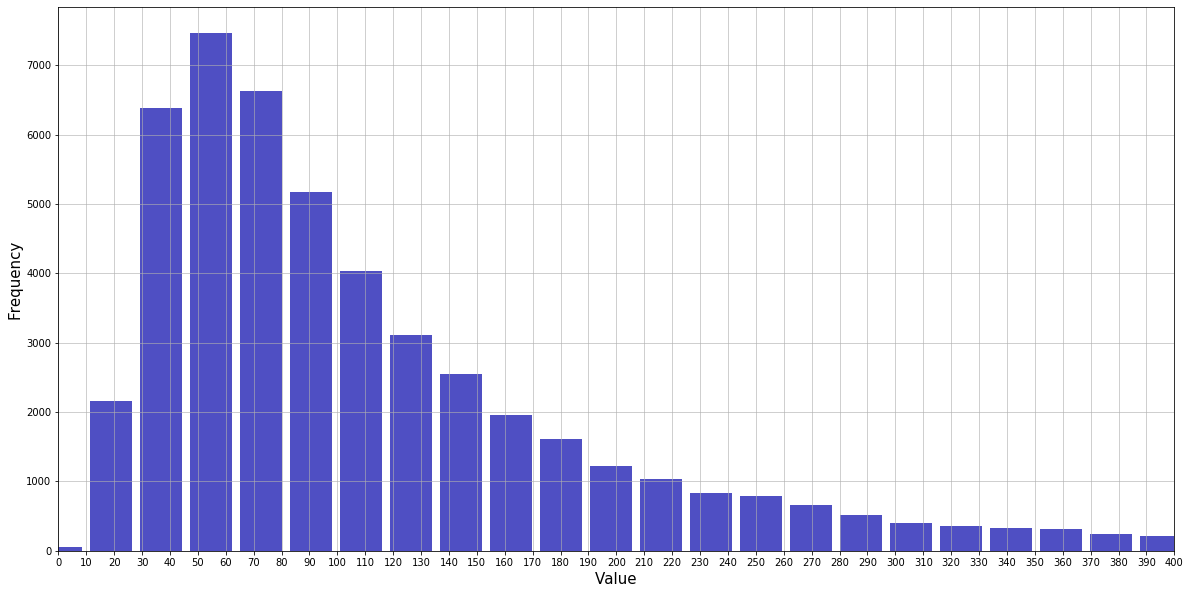

In [7]:
hist,bin_edges = np.histogram(points_df.h, bins = 80)
plt.figure(figsize=[20,10])

plt.bar(bin_edges[:-1], hist, width = 15, color='#0504aa',alpha=0.7)
plt.xlim(min(bin_edges), max(bin_edges))
plt.grid(alpha=0.75)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(ticks = [10*i for i in range(0, 50)])
plt.xlim(right=400)
plt.show()

Next code applies various filter sizes and stores prediction in file "preds.csv". Each row contains the information about the left coordinate of window with it's height, width and the prediction score

In [198]:
img_width, img_height = 224, 224
for id in range(2726, 2727):
    img = cv.imread('train_images/' + train['ImageId'][id] + '.jpg')
    print("id = " + str(id))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    print(img.shape)
    c = pd.DataFrame([], columns =list('ijhwp'))
    #c = pd.read_csv('preds2738.csv')
    for h_y in [20, 30, 40, 50,60, 75, 90, 110, 125, 250]:
    #for h_y in [90, 110, 125, 250]:
        print("h_y = " + str(h_y))
        h_x = int(3*h_y/2)
        grid = 30
        preds = np.zeros((int((img.shape[0] - h_y) / grid) + 1, int((img.shape[1] - h_x)/ grid) + 1))
        for i in range (0, img.shape[0] - h_y, grid):
            part = []
            for j in range(0, img.shape[1] - h_x, grid): 

                part.append(cv.resize(img[i:i+h_y, j:j+h_x], (img_width, img_height), cv.INTER_CUBIC))
            part = np.array(part)
            preds[int(i/grid), :] = np.squeeze(model2.predict_on_batch(part))
        for i in range(0, preds.shape[0]):
            for j in range(0, preds.shape[1]):
                if (preds[i, j] > 0.5):
                    l = pd.DataFrame([[grid * i, grid * j, h_y, h_x, preds[i, j]]], columns =list('ijhwp'))
                    c = c.append(l, ignore_index=True)
        c.to_csv('preds' + str(id) + '.csv', index=False)
        print(len(c))
    c

id = 2726
(2710, 3384, 3)
h_y = 20
0
h_y = 30
2
h_y = 40
15
h_y = 50
44
h_y = 60
103
h_y = 75
213
h_y = 90
364
h_y = 110
533
h_y = 125
718
h_y = 250
897


(Optional) For each box producing the shifting boxes which intersect with this one, potentially could 
determine the more presize window by shifting the current one 

In [105]:
'''
v = pd.DataFrame([], columns =list('ijp'))
s_x = int(h_x / 3)
s_y = int(h_y / 3)
for k in range(-1, 2):
    for l in range(-1, 2):
        if (k == 0 and l == 0):
            continue
        vi = []
        vp = []
        parts = []
        for t in c.values:
            if (t[0] + k * s_y  in range(0, img.shape[0] - h_y) and t[1] + l*s_x in range(0, img.shape[1] - h_x)):
                vi.append((t[0]+k*s_y, t[1] + l*s_x))
                vp.append(cv.resize(img[t[0]+k*s_y:t[0]+k*s_y+h_y, t[1]+l*s_x:t[1]+l*s_x+h_x], (img_width, img_height), cv.INTER_CUBIC))   
                #model2.predict(np.expand_dims(cv.resize(img[t[0]+k*s_y:t[0]+k*s_y+h_y, t[1]+l*s_x:t[1]+l*s_x+h_x], (img_width, img_height), cv.INTER_CUBIC), 0))))
        vi = pd.DataFrame(vi, columns = list('ij'))
        vp = np.array(vp)
        preds = model2.predict(vp)
        preds = pd.DataFrame(preds, columns = list('p'))
        preds = pd.merge(vi, preds, left_index = True, right_index = True)
        v = v.append(preds, ignore_index = True)
        print("k = " + str(k) + ", l = " + str(l) + ", len(v) = " + str(v.shape))
v
'''

k = -1, l = -1, len(v) = (298, 3)
k = -1, l = 0, len(v) = (600, 3)
k = -1, l = 1, len(v) = (891, 3)
k = 0, l = -1, len(v) = (1189, 3)
k = 0, l = 1, len(v) = (1480, 3)
k = 1, l = -1, len(v) = (1778, 3)
k = 1, l = 0, len(v) = (2080, 3)
k = 1, l = 1, len(v) = (2371, 3)


,i,j,p
0,1094,340,0.035132
1,1134,260,0.005952
2,1134,340,0.424677
3,1174,300,0.414959
4,1174,340,0.153279
...,...,...,...
2366,2226,1060,0.000225
2367,2226,1100,0.000005
2368,2226,1140,0.000002
2369,2226,1180,-0.000026


Reading the particular image

In [199]:
#f = c.append(v, ignore_index=True)
#f.drop_duplicates(['i', 'j'], inplace=True)
im_id = 2726
c = pd.read_csv('preds' + str(im_id) + '.csv')
f = c[c.p >= 0.5]
#f.reset_index(inplace=True)
#f.drop(columns=['index'], inplace=True)
f

,i,j,h,w,p
0,1770,1830,30,45,0.716985
1,1800,2310,30,45,0.852582
2,1680,1470,40,60,0.651684
3,1740,750,40,60,0.716373
4,1740,1770,40,60,0.778324
...,...,...,...,...,...
892,1890,2970,250,375,1.001382
893,1890,3000,250,375,1.001382
894,1920,2940,250,375,0.552151
895,1920,2970,250,375,1.000893


In [200]:
def iou(a, b):
    #print(a)
    #print(str(b[0]) + " " +  str(b[1]) + " " + str(b[2]) + " " + str(b[3]))
    if max(a[0], b[0]) >= min(a[2], b[2]) or max(a[1], b[1]) >= min(a[3], b[3]):
        return 0
    else:
        inter = (min(a[2], b[2]) - max(a[0], b[0])) * (min(a[3], b[3]) - max(a[1], b[1]))
        return inter / ((a[2] - a[0]) *(a[3]-a[1])+(b[2]-b[0])*(b[3]-b[1]) - inter)

In [201]:
def int_to_sm(a, b):
    if max(a[0], b[0]) >= min(a[2], b[2]) or max(a[1], b[1]) >= min(a[3], b[3]):
        return 0
    else:
        inter = (min(a[2], b[2]) - max(a[0], b[0])) * (min(a[3], b[3]) - max(a[1], b[1]))
        return inter / np.min(((a[2] - a[0]) *(a[3]-a[1]), (b[2]-b[0])*(b[3]-b[1])))

In [202]:
def suppression(ar):
    q = ar[["sx", "sy", "ex", "ey"]]
    q["sq"] = 0
    q["sq"].astype('int64')
    q["sq"] = q.apply(lambda x: (x["ey"] - x["sy"]) *(x["ex"]-x["sx"]), axis=1)
    t = pd.DataFrame([], columns = ["sx", "sy", "ex", "ey", "sq"])
    while len(q.values > 0):
        k = q.loc[q.sq.idxmax(), :]
        q['s'] = q.apply(lambda x: int_to_sm((x['sx'], x['sy'], x['ex'], x['ey']), k[0:4]), axis=1)
        l = q[q.s >= 0.8]
        l.drop(columns=["s"], inplace=True)
        t = t.append(k)
        q = q.merge(l, on = ['sx', 'sy', 'ex', 'ey'], indicator = True, how = 'left', suffixes = ('', '_y'))
        q = q[q._merge == 'left_only']
        q.drop(columns=["_merge", "sq_y"], inplace=True)
    t["sx"] = pd.to_numeric(t["sx"], downcast = "integer")
    t["sy"] = pd.to_numeric(t["sy"], downcast = "integer")
    t["ex"] = pd.to_numeric(t["ex"], downcast = "integer")
    t["ey"] = pd.to_numeric(t["ey"], downcast = "integer")

    t["sh"] = t.apply(lambda x: np.max([(x["ex"] - x["sx"])/(x["ey"] - x["sy"]), (x["ey"] - x["sy"])/(x["ex"] - x["sx"])]), axis = 1) 
    t = t[t.sh < 6]
    t.reset_index(inplace=True)
    t.drop(columns=['index', 'sq'], inplace=True)
    t = ar.merge(t, on = ['sx', 'sy', 'ex', 'ey'],  how = 'inner', suffixes = ('', '_y'))
    return t

Eliminating images with high IOU

In [203]:
t = pd.DataFrame([], columns =list('ijhwp'))
while len(f.values > 0):
    l = []
    k = f.loc[f.p.idxmax(), :]
    f['s'] = f.apply(lambda x: iou((x['i'], x['j'], x['i'] + x['h'], x['j'] + x['w']), (k[0], k[1], k[0] + k[2], k[1] + k[3])), axis=1)
    l = f[f.s >= 0.5]
    l.drop(columns=["s"], inplace=True)
    t = t.append(k)
    f = f.merge(l, on = ['i', 'j', 'h', 'w'], indicator = True, how = 'left', suffixes = ('', '_y'))
    f = f[f._merge == 'left_only']
    f.drop(columns=["_merge", "p_y"], inplace=True)
t["i"] = pd.to_numeric(t["i"], downcast = "integer")
t["j"] = pd.to_numeric(t["j"], downcast = "integer")
t["h"] = pd.to_numeric(t["h"], downcast = "integer")
t["w"] = pd.to_numeric(t["w"], downcast = "integer")
t.reset_index(inplace=True)
t.drop(columns=['index'], inplace=True)
t

,i,j,h,w,p,s
0,1740,1800,60,90,1.001382,NaN
1,1770,1800,60,90,1.001382,0.333333
2,1770,2190,60,90,1.001382,0.000000
3,1800,2490,60,90,1.001382,0.000000
4,1800,2550,60,90,1.001382,0.200000
...,...,...,...,...,...,...
194,1740,1680,75,112,0.584590,0.000000
195,1800,2580,50,75,0.570075,0.000000
196,1800,3030,75,112,0.523326,0.000000
197,2490,840,125,187,0.518811,0.000000


Eliminating boxes which are included on 80% into another box

In [204]:
new = t.copy()
new["sx"] = new["j"]
new["sy"] = new["i"]
new["ex"] = new["j"] + new["w"]
new["ey"] = new["i"] + new["h"]
new.drop(columns=["i", "j", "h", "w"], inplace=True)
q = suppression(new)
q = q[["sx", "sy", "ex", "ey", "p"]]
q

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,sx,sy,ex,ey,p
0,780,1710,915,1800,1.001382
1,2400,1740,2775,1990,1.001382
2,2790,1740,3165,1990,1.001382
3,2910,1770,3285,2020,1.001382
4,2970,1830,3345,2080,1.001382
5,2550,1740,2925,1990,1.001382
6,2460,1680,2835,1930,1.001381
7,2790,1830,3165,2080,1.001381
8,750,1740,862,1815,1.001374
9,660,1680,847,1805,1.001347


Making predictions for the given image with dataframe of final boxes. Green frame is the actual box for the training image, red frame - is the predicted one

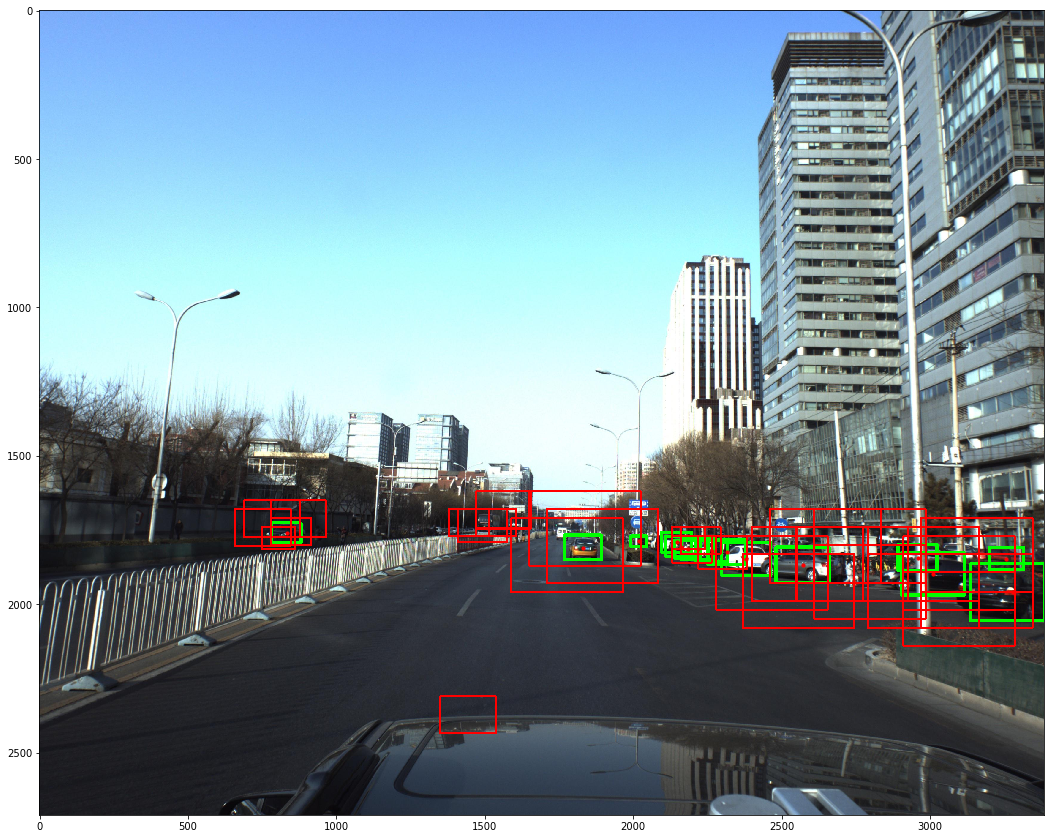

In [205]:
img_width, img_height = 224, 224
img = cv.imread('train_images/' + train['ImageId'][im_id] + '.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
#img = cv.resize(img, (img_width, img_height), cv.INTER_CUBIC)
xy = get_img_coords(train['PredictionString'][im_id])
rec = []
for l in range(0, xy[0].shape[0]):
    color = (0, 255, 0)
    s_x = int(max(0, min(img.shape[1], xy[3][l]) - 22*150/xy[2][l]))
    s_y = int(max(min(img.shape[0], xy[4][l])-22*100/xy[2][l], 0))
    e_x = int(min(max(0, xy[3][l])+22*150/xy[2][l], img.shape[1]))
    e_y = int(min(max(0, xy[4][l])+22*100/xy[2][l], img.shape[0]))
    rec.append((s_y, s_x, e_y, e_x, xy[2][l]))
    cv.rectangle(img, (s_x, s_y), (e_x, e_y), color, 10)
for i in range(0, len(q.values)):
    '''
for i in range(38, 39):
    s_x = t.iloc[i, 1]
    s_y = t.iloc[i, 0]
    e_x = t.iloc[i, 1] + t.iloc[i, 3]
    e_y = t.iloc[i, 0] + t.iloc[i, 2]
    '''
    if q.loc[i, 'p'] >= 0.96:
        cv.rectangle(img, (q.loc[i, 'sx'], q.loc[i, 'sy']), (q.loc[i, 'ex'], q.loc[i, 'ey']), (255, 0, 0), 5)
plt.figure(figsize=(18,18))
plt.imshow(img)
plt.scatter(*get_img_coords(train['PredictionString'][im_id])[3:], color='red', s=10)
rec = np.array(rec)

p contains the ground true boxes with cars

In [206]:
p = pd.DataFrame(rec, columns = ["sy", "sx", "ey", "ex", "z"])
p["sx"] = pd.to_numeric(p["sx"], downcast = "integer")
p["sy"] = pd.to_numeric(p["sy"], downcast = "integer")
p["ex"] = pd.to_numeric(p["ex"], downcast = "integer")
p["ey"] = pd.to_numeric(p["ey"], downcast = "integer")
p["w"] = (p.ex - p.sx)*p.z/(44*150)
p

,sy,sx,ey,ex,z,w
0,1864,3135,2054,3384,23.1703,0.874152
1,1807,2481,1926,2660,36.8862,1.000398
2,1793,2298,1903,2463,39.9046,0.997615
3,1767,1769,1850,1893,53.2735,1.000896
4,1726,783,1792,882,66.2075,0.993112
5,1809,3200,1884,3314,58.1345,1.004141
6,1827,2903,1969,3116,31.0553,1.002239
7,1799,2892,1886,3023,50.4558,1.001471
8,1781,2252,1866,2379,51.9023,0.998726
9,1786,2211,1858,2319,61.0607,0.999175


For each prediction find it's maximal IOU with one of the ground true boxes. If it is low enough then we add this box as a negative example of background to the training set for futher learning of neural network

In [207]:
q = t
q['s'] = q.apply(lambda x: np.max([iou((x['i'], x['j'], x['i'] + x['h'], x['j'] + x['w']), p.iloc[i, 0:4]) for i in range(0, len(p.values))]), axis=1)
q

,i,j,h,w,p,s
0,1740,1800,60,90,1.001382,0.233454
1,1770,1800,60,90,1.001382,0.524679
2,1770,2190,60,90,1.001382,0.504476
3,1800,2490,60,90,1.001382,0.217500
4,1800,2550,60,90,1.001382,0.217500
...,...,...,...,...,...,...
194,1740,1680,75,112,0.584590,0.062770
195,1800,2580,50,75,0.570075,0.147760
196,1800,3030,75,112,0.523326,0.119590
197,2490,840,125,187,0.518811,0.000000


These predictions are wrong since they don't intersect match with ground true cars

In [208]:
n = q[q.s < 0.4]
n.reset_index(inplace=True)
n.drop(columns=['index'], inplace=True)
n

,i,j,h,w,p,s
0,1740,1800,60,90,1.001382,0.233454
1,1800,2490,60,90,1.001382,0.217500
2,1800,2550,60,90,1.001382,0.217500
3,1770,1830,75,112,1.001382,0.338297
4,1800,2370,75,112,1.001382,0.356322
...,...,...,...,...,...,...
162,1740,1680,75,112,0.584590,0.062770
163,1800,2580,50,75,0.570075,0.147760
164,1800,3030,75,112,0.523326,0.119590
165,2490,840,125,187,0.518811,0.000000


Save them into training set in the backround class

In [209]:
img = cv.imread('train_images/' + train['ImageId'][im_id] + '.jpg')
for i in range(0, len(n.values)):
    part = img[n.iloc[i, 0]:n.iloc[i, 0]+n.iloc[i, 2], n.iloc[i, 1]:n.iloc[i, 1]+n.iloc[i, 3]]
    imageio.imwrite('Models/bg/new_' + str(im_id) + ' '+ str(i) + '.jpg', part)

Some scripts stuff

In [139]:
shutil.rmtree('Models/.ipynb_checkpoints')

In [58]:
root = 'test_images'
root = pathlib.Path(root)
test_paths = list(root.glob('*jpg'))
test_paths = [str(path)[len('test_images')+1:] for path in test_paths]
len(test_paths)

2021

In [43]:
tp = np.array(test_paths)
tp = pd.DataFrame(tp, columns=["name"])
tp.to_csv('test_names.csv', index=False)

In [3]:
'''
z = zipfile.ZipFile('my_model.zip')
z.extractall('/')
'''
#for s in all_cars_paths:
#    shutil.move(s, 'train_images/' + s)


"\nz = zipfile.ZipFile('my_model.zip')\nz.extractall('/')\n"

In [85]:
'''
root = 'tmp'
root = pathlib.Path(root)
to_del = list(root.glob('*'))
to_del = [str(path) for path in to_del]
for i in to_del:
    os.remove(str(i))

for i in range(47000, new_cars.shape[0]):
    shutil.copy(new_cars[i], 'tmp/' + new_cars[i][ len('Models/bg/'):])
import shutil
#shutil.rmtree('Models/bg/.ipynb_checkpoints')
shutil.make_archive('new', 'zip', 'tmp')
'''

In [15]:
X = np.matrix([[1, 1, 1, 1, 1], [1.2, 3.2, 5.1, 3.5, 2.6]]).T
y = np.matrix([[7.8, 1.2, 6.4, 2.6, 8.1]]).T
X[0, 1]

1.2

In [26]:
z = np.matmul(np.linalg.inv(np.matmul(X.T, X) + 100*np.eye(X.shape[1])), np.matmul(X.T, y))
z

matrix([[0.17916378],
        [0.46716685]])

In [25]:
10*np.eye(X.shape[1])

array([[10.,  0.],
       [ 0., 10.]])